# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Introduction

Grid algorithms... three alternative:

1. Conjugate priors

2. ABC

3. MCMC



## Poisson processes

In Chapter 7, we solved the World Cup problem using a Poisson process to model goals in a soccer game as random events that are equally likely to occur at any point during a game.

We used a gamma distribution to represent the prior distribution of `lam`, the goal-scoring rate.  And we used a Poisson distribution to compute the probability of the data, the observed number of goals in a game.

Here's the prior distribution again.

In [101]:
def make_pmf(dist, qs):
    """Make a discrete approximation.
    
    dist: SciPy distribution object
    qs: quantities
    
    returns: Pmf
    """
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [102]:
from scipy.stats import gamma

alpha = 1.4
lams = np.linspace(0, 10, 101)
    
dist = gamma(alpha)
prior = make_pmf(dist, lams)

And here's the likelihood of scoring 4 goals for each possible value of `lam`.

In [103]:
from scipy.stats import poisson

k = 4
likelihood = poisson(lams).pmf(k)

We did the update by multiplying the prior by the likelihood and normalizing the result.

In [104]:
posterior = prior * likelihood
posterior.normalize()

0.05015532557804499

And here's the result.

In [105]:
def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
             ylabel='PMF',
             title=title)

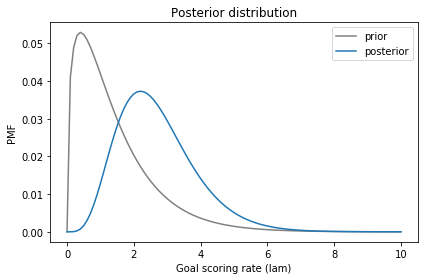

In [106]:
prior.plot(label='prior', color='gray')
posterior.plot(label='posterior', color='C0')

decorate_rate('Posterior distribution')

## The conjugate prior

At the time, I said that I chose the gamma distribution for three reasons:

1. The goal scoring rate is continuous and cannot be less than 0, and the gamma distribution is appropriate for this kind of quantity.

2. The gamma distribution has only one parameter, `alpha`, which is the mean.  So it's easy to construct a gamma distribution with the mean we want.

3. The shape of the Gamma distribution is a reasonable choice, given what we know about soccer.

And I said there was a fourth reason that I would reveal in Chapter 17, so now is the time.

The other reason I chose the gamma distribution is that it is the "conjugate prior" of the Poisson distribution, so-called because the two distributions are connected or coupled, which is what "conjugate" means.

In the next section I'll explain *how* they are connected, but first I'll show you the consequence of this connection, which is that there is a simple closed-form way to compute the posterior distribution.

However, in order to demonstrate it, we have to switch from the one-parameter version of the gamma distribution to the two-parameter version.  Since the first parameter is called `alpha`, you might guess that the second parameter is called `beta`.

The following function takes `alpha` and `beta`, and makes an object that represents a gamma distribution with those parameters.

In [107]:
def make_gamma(alpha, beta):
    """Makes a gamma object.
    
    alpha: shape parameter
    beta: scale parameter
    
    returns: gamma object
    """
    dist = gamma(alpha, scale=1/beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

Here's the prior distribution with `alpha=1.4` again and `beta=1`. 

In [108]:
alpha = 1.4
beta = 1

prior_gamma = make_gamma(alpha, beta)
prior_gamma.mean()

1.4

Now to do a Bayesian update, I claim, all we have to do is make a gamma distribution with parameters `alpha+k` and `beta+1`.

In [109]:
def update_gamma(prior, data):
    k, t = data
    alpha = prior.alpha + k
    beta = prior.beta + t
    return make_gamma(alpha, beta)

Here's how we update it with the data, which is 4 goals in 1 game.

In [110]:
data = 4, 1
posterior_gamma = update_gamma(prior_gamma, data)

After all the work we did in Chapter 7, it might seem absurd that we can do a Bayesian update by adding two pairs of numbers.
So let's confirm that it works.

I'll evaluate the posterior distribution for each quantity in `lams` and put the results in a `Pmf` object.

In [111]:
posterior_conjugate = make_pmf(posterior_gamma, lams)

So `posterior_conjugate` contains a discrete approximation of the posterior distribution we just computed using the conjugate prior.
The following figure shows the result along with the posterior we computed using the grid algorithm.

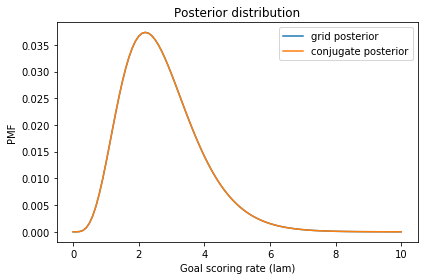

In [112]:
posterior.plot(label='grid posterior', color='C0')
posterior_conjugate.plot(label='conjugate posterior', color='C1')

decorate_rate('Posterior distribution')

They are the same other than small differences due to floating-point approximations.

In [113]:
np.max(np.abs(posterior - posterior_conjugate))

4.163336342344337e-17

## What the actual?

To understand how that works, we'll write the PDF of the gamma prior and the PMF of the Poisson likelihood, then multiply them together, because that's what the Bayesian update does.
We'll see that the result is a gamma distribution, and we'll derive its parameters.

Here's the PDF of the gamma prior, which is the probability density for each value of $\lambda$, given parameters $\alpha$ and $\beta$:

$\mathrm{p}_{gamma}(\lambda; \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha-1}e^{-\beta \lambda}$

The first term does not depend on $\lambda$; it is only needed to normalize the distribution.
Since we are planning to normalize the posterior distribution anyway, we don't really need it.
So I'll write

$\mathrm{p}_{gamma}(\lambda; \alpha, \beta) \sim \lambda^{\alpha-1}e^{-\beta \lambda}$

where $\sim$ means "is proportional to".

Now suppose a team scores $k$ goals in $t$ games.  
The probability of this data is given by PMF of the Poisson distribution, which is a function of $k$ with $\lambda t$ as a parameter.

$\mathrm{p}_{Poisson}(k; \lambda t) = \frac{t^k}{k!} \lambda^k e^{-\lambda t}$

Again, the first term is a normalizing constant that does not depend on $k$, so we can write:

$\mathrm{p}_{Poisson}(k; \lambda) \sim \lambda^k e^{-\lambda t}$

Omitting the normalizing constants makes it clearer that the gamma and Poisson distributions have the same functional form.
When we multiply them together, we can pair up the factors and add up the exponents.
The result is the unnormalized posterior distribution,

$ \lambda^{\alpha-1+k} e^{-(\beta + t) \lambda}$

which we can recognize as an unnormalized gamma distribution with parameters $\alpha + k$ and $\beta + t$.

This derivation provides insight into what the parameters of the posterior distribution mean: $\alpha$ reflects the number of events that have occurred; $\beta$ reflects the elapsed time.

## Binomial likelihood

As a second example, let's look again at the Euro problem.
When we solved it with a grid algorithm, we started with a uniform prior:

In [125]:
from utils import make_uniform

uniform = make_uniform(0, 1, 101, 'uniform')

We used the binomial distribution to compute the likelihood of the data, which was 140 heads out of 250 attempts.

In [126]:
from scipy.stats import binom

k, n = 140, 250
xs = uniform.qs

likelihood = binom.pmf(k, n, xs)

Then we computed the posterior distribution in the usual way.

In [127]:
posterior = uniform * likelihood
posterior.normalize()

0.0039446175693263405

We can solve this problem more efficiently using the conjugate prior of the binomial distribution, which is the beta distribution.

The beta distribution is bounded between 0 and 1, so it works well for representing the distribution of a probability like `x`.
It has two parameters, called `alpha` and `beta`, that determine the shape of the distribution.

SciPy provides an object called `beta` that represents a beta distribution.
The following function takes `alpha` and `beta` and returns a new `beta` object.

In [128]:
import scipy.stats

def make_beta(alpha, beta):
    """Makes a beta object.
    
    alpha: shape parameter
    beta: scale parameter
    
    returns: gamma object
    """
    dist = scipy.stats.beta(alpha, beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

It turns out that the uniform distribution, which we used as a prior, is the beta distribution with parameters `alpha=1` and `beta=1`.
So we can make a `beta` object that represents a uniform distribution, like this:

In [129]:
alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta)
prior_beta.mean()

0.5

Now let's figure out how to do the update.  As in the previous example, we'll write the PDF of the prior distribution and the PMF of the likelihood function, and multiply them together.  We'll see that the product has the same form as the prior, and we'll derive its parameters.

Here is the PDF of the beta distribution, which is a function of $x$ with $\alpha$ and $\beta$ as parameters.

$ \mathrm{p}_{beta}(x; \alpha, \beta) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)} x^{\alpha-1} (1-x)^{\beta-1}$ 

The first factor is a normalizing constant that does not depend on `x`, so we can leave it out and write the unnormalized prior like this:

$ \mathrm{p}_{beta}(x; \alpha, \beta) \sim x^{\alpha-1} (1-x)^{\beta-1}$

That might look familiar: the PMF of the binomial distribution has the same form, but we interpret it as a function of $k$ with $n$ and $x$ as parameters.

$ \mathrm{p}_{binom}(k; n, x) = \binom{n}{k} x^{k} (1-x)^{n-k} $

Again, the first factor does not depend on $x$, so we can write:

$ \mathrm{p}_{binom}(k; n, x) \sim x^{k} (1-x)^{n-k} $

When we multiply the beta prior and the binomial likelihood, the result is

$x^{\alpha-1+k} (1-x)^{\beta-1+n-k} \sim p_{beta}(x; \alpha+k, \beta+n-k)$

which we recognize as an unnormalized beta distribution with parameters $\alpha+k$ and $\beta+n-k$.

So, to do a Bayesian update all we have to do is make a beta distribution with parameters `alpha+k` and `beta+n-k`, as in the following function.

In [130]:
def update_beta(prior, data):
    """Update a beta distribution.
    
    prior: SciPy beta object
    data: number of successes and number of trials (k, n)
    
    returns: SciPy beta object
    """
    k, n = data
    alpha = prior.alpha + k
    beta = prior.beta + n - k
    return make_beta(alpha, beta)

Again, the conjugate prior gives us insight into the meaning of the parameters; $\alpha$ is related to the number of observed successes; $\beta$ is related to the number of failures.

Here's how we do the update with the observed data.

In [131]:
data = 140, 250
posterior_beta = update_beta(prior_beta, data)
posterior_beta.mean()

0.5595238095238095

To confirm that it works, I'll evaluate the posterior distribution for the possible values of `xs` and put the results in a `Pmf`.

In [132]:
posterior_conjugate = make_pmf(posterior_beta, xs)

And we can compare the posterior distribution we just computed with the results from the grid algorithm.

In [133]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

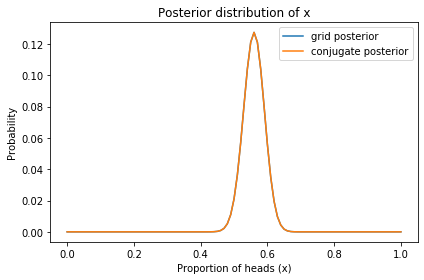

In [134]:
posterior.plot(label='grid posterior')
posterior_conjugate.plot(label='conjugate posterior')

decorate_euro(title='Posterior distribution of x')

They are the same other than small differences due to floating-point approximations.

In [135]:
np.max(np.abs(posterior - posterior_conjugate))

1.8041124150158794e-15

## Lions and tigers and bears

Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are.

During the tour, we see 3 lions, 2 tigers, and one bear. Assuming that every animal had an equal chance to appear in our sample, estimate the prevalence of each species.

What is the probability that the next animal we see is a bear?

To answer this question, we'll use the data to estimate the prevalence of each species, that is, what fraction of the animals belong to each species.

If we know the prevalences, we can use the multinomial distribution to compute the probability of the data.
For example, suppose we know that the fraction of lions, tigers, and bears is 0.4, 0.3, and 0.3, respectively.

In that case the probability of the data is:

In [322]:
from scipy.stats import multinomial

data = np.array([3, 2, 1])
n = data.sum()
ps = 0.4, 0.3, 0.3

multinomial.pmf(data, n, ps)

0.10368

In [323]:
from scipy.stats import multinomial

data = np.array([3, 2, 1])
n = data.sum()
ps = 0.4, 0.3, 0.3

multinomial.pmf(data, n, ps)

0.10368

Now, we could choose a prior for the prevalences and do a Bayesian update using the multinomial distribution to compute the probability of the data.

But there's an easier way, because the multinomial distribution has a conjugate prior: the Dirichlet distribution.

## The Dirichlet distribution

The Dirichlet distribution is a multivariate distribution, like the multivariate normal distribution we used in Chapter 10 to describe the distribution of penguin measurements.  

In that example, the quantities in the distribution are pairs of flipper length and culmen length, and the parameters of the distribution are a vector of means and a matrix of covariances.

In a Dirichlet distribution, the quantities are vectors of probabilities, $\pmb{x}$, and the parameter is a vector, $\pmb{\alpha}$.

An example will make that clearer.  SciPy provides a `dirichlet` object that represents a Dirichlet distribution.
Here's an instance with $\pmb{\alpha} = 1, 2, 3$.

In [324]:
from scipy.stats import dirichlet

alpha = np.array([1, 2, 3])
dist = dirichlet(alpha)

Since we provided three parameters, the result is a distribution of three variables.
If we draw a random value from this distribution, like this:

In [325]:
dist.rvs()

array([[0.21041668, 0.23274015, 0.55684317]])

The result is an array of three values.

The values are bounded between 0 and 1, so they can be interpreted as probabilities.
Even better, they always add up to 1, so they can be interpreted as the probabilities of a set of outcomes that are mutually exclusive and collectively exhaustive.

In [332]:
dist.rvs().sum()

0.9999999999999999

Let's see what the distributions of these values look like.  I'll draw 1000 random vectors from this distribution, like this:

In [333]:
sample = dist.rvs(1000)
sample.shape

(1000, 3)

The result is an array with 1000 rows and three columns.  I'll compute the `Cdf` of the values in each column.

In [334]:
cdfs = [Cdf.from_seq(col) for col in sample.transpose()]

These are the marginal distributions of the three variables.  Here's what they look like.

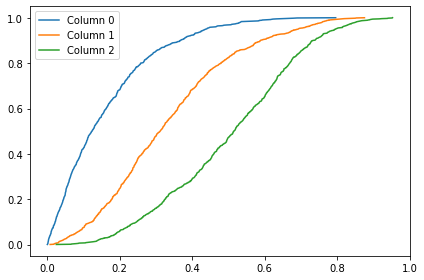

In [335]:
for i, cdf in enumerate(cdfs):
    label = f'Column {i}'
    cdf.plot(label=label)
    
decorate()

Column 0, which corresponds to the lowest parameter, contains the lowest probabilities.
Column 2, which corresponds to the highest parameter, contains the highest probabilities.

We can compute the means of the marginal distributions like this:

In [336]:
alpha / alpha.sum()

array([0.16666667, 0.33333333, 0.5       ])

And the `dist` object can do it for us.

In [337]:
dist.mean()

array([0.16666667, 0.33333333, 0.5       ])

Let's compare those to the means of the samples.

In [306]:
sample.mean(axis=0)

array([0.16415577, 0.32939925, 0.50644498])

That's pretty close.

As it turns out, these marginal distributions are beta distributions.
The following function takes the vector of parameters, `alpha`, and computes the marginal distribution of variable `i`:

In [307]:
def marginal_beta(alpha, i):
    """
    """
    total = alpha.sum()
    return make_beta(alpha[i], total-alpha[i])

The following plot uses this function to plot the marginal beta distributions and compares them to the distributions of the columns in the sample.

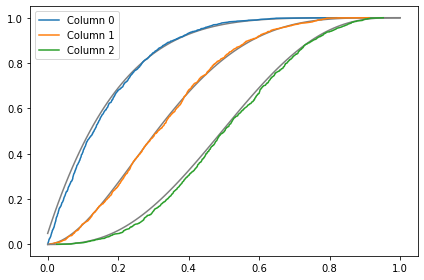

In [308]:
xs = np.linspace(0, 1, 101)

for i, cdf in enumerate(cdfs):
    label = f'Column {i}'
    
    marginal = marginal_beta(alpha, i)
    make_pmf(marginal, xs).make_cdf().plot(color='gray')
    cdf.plot(label=label)

    
decorate()

So that checks out.

This time I will not derive the relationship between the Dirichlet prior and the multinomial likelihood function, but I will tell you how to use this relationship to do a Bayesian update.

If the prior distribution is Dirichlet with parameter vector `alpha` and the data is a vector of observations, `data`, the posterior distribution is Dirichlet with parameter vector `alpha + data`.

As an exercise at the end of this chapter, you can use this method to solve the Lions and Tigers and Bears problem.

## Summary



## Exercises

**Exercise:** In the second version of the World Cup problem, the data we use for the update is not the number of goals in a game, but the time until the first goal (in units of games).

So the probability of the data is given by the exponential distribution rather than the Poisson distribution.  
But it turns out that the gamma distribution is *also* the conjugate prior of the exponential distribution, so there is a simple closed-form way to compute this update, too.

The PDF of the exponential distribution is a function of $t$ with $\lambda$ as a parameter.

$p(t; \lambda) = \lambda e^{-\lambda t}$

Multiply the PDF of the gamma prior by this likelihood, confirm that the result is an unnormalized gamma distribution, and see if you can derive its parameters.

Write a few lines of code to update `prior_gamma` with the data from this version of the problem, which was a goal after 11 minutes, or 11/90 of a game.

In [60]:
# Solution

"""
The unnormalized posterior is

\lambda^{\alpha-1+1} e^{-(\beta + t) \lambda}

which is an unnormalized gamma distribution with parameters
`alpha+1` and `beta+t`, which means that we observed 1 goal
in elapsed time `t`.

So we can use the same update function, and call it like this:
"""

data = 1, t
update_gamma(prior_gamma, data)

In [88]:
from utils import make_uniform

uniform = make_uniform(0, 1, 101, 'uniform')

We used the binomial distribution to compute the likelihood of the data, which was 140 heads out of 250 attempts.

In [95]:
from scipy.stats import binom

k, n = 140, 250
xs = uniform.qs

likelihood = binom.pmf(k, n, xs)

Then we computed the posterior distribution in the usual way.

In [96]:
posterior = uniform * likelihood
posterior.normalize()

0.0039446175693263405

**Exercise:** For problems like the Euro problem where the likelihood function is binomial, we can do a Bayesian update with just a few arithmetic operations, but only if the prior is a beta distribution.

As we saw, the uniform distribution is a beta distribution with particular parameters, but what can we do if the prior distribution we want is not a beta distribution.  For example, in Chapter 3 we also solved the Euro problem with a triangle prior, and a beta distribution cannot be a triangle.

Even so, we can often find a beta distribution that is a good-enough fit for the prior we want.

Here's the triangle prior again.

In [142]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)
xs = uniform.qs

triangle = Pmf(a, xs, name='triangle')
triangle.normalize()

2500

And here's the update.

In [143]:
k, n = 140, 250
likelihood = binom.pmf(k, n, xs)

posterior = triangle * likelihood
posterior.normalize()

0.0070088425900585345

See if you can find a beta distribution that fits the triangle prior, then update it using `update_beta`.

Then use `make_pmf` to make a `Pmf` that approximates the posterior distribution and compare it to the posterior we just computed using a grid algorithm.  How big is the largest difference between them?

To get you started, here's the beta distribution that we used as a uniform prior.

In [151]:
alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta)
prior_beta.mean()

0.5

And here's what it looks like compared to the triangle prior.

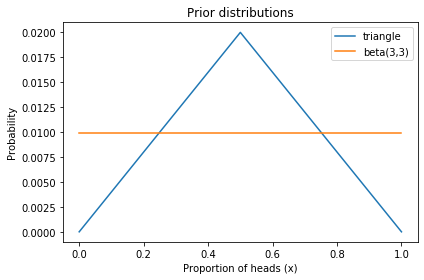

In [152]:
prior_pmf = make_pmf(prior_beta, xs)

triangle.plot(label='triangle')
prior_pmf.plot(label='beta(3,3)')

decorate_euro('Prior distributions')

In [146]:
# Solution

data = 140, 250
posterior_beta = update_beta(prior_beta, data)
posterior_beta.mean()

0.55859375

In [147]:
# Solution

posterior_conjugate = make_pmf(posterior_beta, xs)

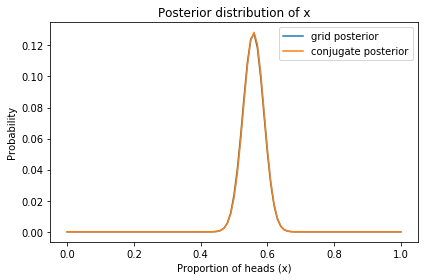

In [148]:
# Solution

posterior.plot(label='grid posterior')
posterior_conjugate.plot(label='conjugate posterior')

decorate(xlabel='Proportion of heads (x)',
         ylabel='Probability',
         title='Posterior distribution of x')

In [149]:
# Solution

np.max(np.abs(posterior - posterior_conjugate))

0.0032992381834314743

**Exercise:**  [3Blue1Brown](https://en.wikipedia.org/wiki/3Blue1Brown) YouTube channel about math; if you are not already aware of it, I recommend it highly.

In [this video](https://www.youtube.com/watch?v=8idr1WZ1A7Q) the narrator presents this problem:

> You are buying a product online and you see three sellers offering the same product at the same price.  One of them has a 100% positive rating, but with only 10 reviews.  Another has a 96% positive rating with 50 total reviews.  And yet another has a 93% positive rating, but with 200 total reviews.
>
>Which one should you buy from?

Now, let's think about how to model this scenario.  Suppose each seller has some unknown probability, `x`, of providing satisfactory service and getting a positive rating, and we want to choose the seller with the highest value of `x`.

This is not the only model, and it is not necessarily the best.  An alternative would be something like item response theory, where sellers have varying ability to provide satisfactory service and customers have varying difficulty of being satisfied.

But the first model has the virtue of simplicity, so let's see where it gets us.

As a prior, I suggest we use a beta distribution with `alpha=8` and `beta=2`.  Here's what it looks like:

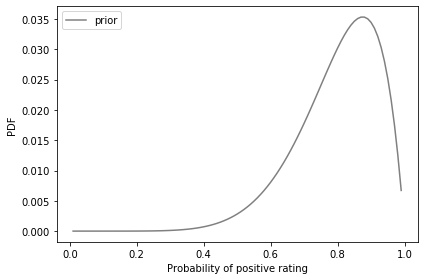

In [236]:
prior = make_beta(8, 2)

xs = np.linspace(0.01, 0.99, 99)
prior_pmf = make_pmf(prior, xs)
prior_pmf.plot(color='gray', label='prior')

decorate(xlabel='Probability of positive rating',
         ylabel='PDF')

This prior implies that most sellers are satisfactory most of the time, but none are perfect.

1. Use the data to update this prior for the three sellers and plot the posterior distributions.  Which seller has the highest posterior mean?

2. How confident should we be about our choice?  That is, what is the probability that the seller with the highest posterior mean actually has the highest value of `x`?

3. Consider an alternative prior with `alpha=0.7` and `beta=0.5`.  What does this prior look like and what does it imply about sellers?

4. Run the analysis again with the alternative prior and see what effect it has on the results.

You might notice that I restricted the range of `xs` so it does not include 0 and 1.  I did that because when the parameters of the beta distribution are less than 1, the probability density goes to infinity at 0 and 1.  From a mathematical point of view, that's not a problem; it is still a proper probability distribution.  But from a computational point of view, it means we have to avoid evaluating the PDF at 0 and 1. 

In [229]:
# Solution

data1 = 10, 10
data2 = 48, 50
data3 = 186, 200

In [230]:
# Solution

seller1 = update_beta(prior, data1)
seller2 = update_beta(prior, data2)
seller3 = update_beta(prior, data3)

In [231]:
# Solution

seller1_pmf = make_pmf(seller1, xs)
seller2_pmf = make_pmf(seller2, xs)
seller3_pmf = make_pmf(seller3, xs)

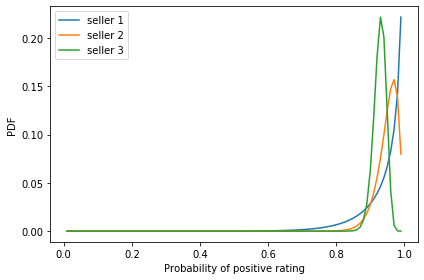

In [232]:
# Solution

seller1_pmf.plot(label='seller 1')
seller2_pmf.plot(label='seller 2')
seller3_pmf.plot(label='seller 3')

decorate(xlabel='Probability of positive rating',
         ylabel='PDF')

In [233]:
# Solution

seller1.mean(), seller2.mean(), seller3.mean()

(0.9545454545454546, 0.9509803921568627, 0.927860696517413)

In [234]:
# Solution

iters = 10000
a = np.empty((3, iters))

a[0] = seller1.rvs(iters)
a[1] = seller2.rvs(iters)
a[2] = seller3.rvs(iters)

In [235]:
# Solution

best = np.argmax(a, axis=0)
Pmf.from_seq(best)

,probs
0,0.6295
1,0.3138
2,0.0567


**Exercise:** Use a Dirichlet prior with parameter vector `alpha = [1, 1, 1]` to solve the Lions and Tigers and Bears problem:

>Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are.
>
>During the tour, we see 3 lions, 2 tigers, and one bear. Assuming that every animal had an equal chance to appear in our sample, estimate the prevalence of each species.
>
>What is the probability that the next animal we see is a bear?


In [316]:
prior_alpha = np.array([1, 1, 1])
data = 3, 2, 1

In [317]:
posterior_alpha = prior_alpha + data

In [318]:
dist = dirichlet(posterior_alpha)

array([0.44444444, 0.33333333, 0.22222222])

In [321]:
index = ['lion', 'tiger', 'bear']
pd.DataFrame(dist.mean(), index, columns=['prob'])

,prob
lion,0.444444
tiger,0.333333
bear,0.222222
